In [1]:
import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(12)
print("TensorFlow version:", tf.__version__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

from surface_simulation_functions import surface_from_Efth
from wave_physics_functions import * # spectrum_from_kth_to_kxky,spectrum_from_fth_to_kxky,f_from_k

2023-08-21 09:39:16.351611: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.12.1


In [2]:
file = '/home/mdecarlo/Documents/PROJETS/TCFO_Tempetes_vs_CFOSAT/WaveGroups/Notebook_for_paper/wavegroups_stdhs/Spectrum_L2S_ind9_35.nc'

In [3]:
def spec_for_surface_from_Efth(Efth,f_vec,th_vec,seed=0,nx=2048,ny=2048-2,dx=10,dy=10,D=None,iswvnb=0):

    g=9.81
    #
    # Here we start by adding last and first value at the border of the spectrum in order to deal with the -180/180 gap
    spec = xr.DataArray(Efth,
        dims=['n_phi','nk'],
        coords={
            "phi_vector" : (["n_phi"], th_vec),
            "k_vector" : (["nk"], f_vec),
            },
        )

    spec_bis = xr.concat([spec.isel(n_phi=-1),spec,spec.isel(n_phi=0)],dim="n_phi")
    # --- change the first and last new values to have a 2pi revolution ---------------
    A = np.concatenate([[-360],np.zeros((spec.sizes['n_phi'])),[360]])
    factor = xr.DataArray(A, dims="n_phi")
    spec_bis['phi_vector'].values = spec_bis['phi_vector']+factor
    spec_bis = spec_bis.interpolate_na(dim='n_phi')

    # Then, turning the spectrum to cartesian coordinates in order 
    # to apply the Inverse Fourier to it and get the surface                   
    #
    # -- get cartesian spectrum ------
    if iswvnb:
        Ekxky0, kx, ky = spectrum_from_kth_to_kxky(np.squeeze(spec_bis.compute().data),  spec_bis['k_vector'].compute().data,spec_bis["phi_vector"].compute().data)
    else:
        Ekxky0, kx, ky = spectrum_from_fth_to_kxky(np.squeeze(spec_bis.compute().data),  spec_bis['k_vector'].compute().data,spec_bis["phi_vector"].compute().data)

    # -- GET THE INTERPOLATION GRID for the spectrum -----
    # -- get kx,ky values we want from the surface we want ---------
    dkx = 2*np.pi/(dx*nx)
    dky = 2*np.pi/(dy*ny)
    kX0 = np.fft.fftshift(np.fft.fftfreq(nx,d=dx))*2*np.pi
    kY0 = np.fft.fftshift(np.fft.fftfreq(ny,d=dy))*2*np.pi

    kX,kY = np.meshgrid(kX0,kY0)# , indexing='ij')

    # --- compute associated Kf, Phi(in deg) ---------
    kK = (np.sqrt(kX**2+kY**2))
    if iswvnb:
        kF = kK
    else:
        kF = f_from_k(kK,D=D)

    kPhi = np.arctan2(kY,kX)*180/np.pi
    kPhi[kPhi<0]=kPhi[kPhi<0]+360

    # create a dataArray with the new (i.e. wanted) values of F written in a cartesian array
    kF2 = xr.DataArray(kF, coords=[("ky", kY0), ("kx",kX0)])

    kPhi2 = xr.DataArray(kPhi, coords=[("ky", kY0), ("kx",kX0)])
    FPhi2s = xr.Dataset(
    {'kF': kF2,
    'kPhi': kPhi2}
    ).stack(flattened=["ky", "kx"])

    Ekxky = xr.DataArray(Ekxky0, dims=("nf", "n_phi"), coords={"nf":f_vec , "n_phi":spec_bis['phi_vector']})
    B = Ekxky.interp(nf=FPhi2s.kF,n_phi=FPhi2s.kPhi,kwargs={"fill_value": 0})
    B.name='Ekxky_new'
    B0 = B.reset_coords(("nf","n_phi"))
    Ekxky_for_surf = B0.Ekxky_new.unstack(dim='flattened')
    
    return Ekxky_for_surf,kX,kY

In [4]:
%%time
Hsfac=1

DS = xr.open_dataset(file)
Hs_9 = DS['Hs_ind_9_box'].compute().data
Hs_9_L2S = DS['Hs_ind_9_L2S'].compute().data
Hs_35 = DS['Hs_ind_35_box'].compute().data
Hs_35_L2S = DS['Hs_ind_35_L2S'].compute().data

Efth = DS['Spec_L2S_ind_35_1Sided'].compute().data*Hs_35**2/Hs_35_L2S**2*Hsfac**2
th_vec = DS['phi_vector_L2S_ind_35'].compute().data
f_vec = DS['k_vector'].compute().data
nx_big = 2**12
ny_big = nx_big-2
dx_big=14
dy_big=14
seed=0

print(Efth.shape)
print(th_vec.shape)
print(f_vec.shape)

Ekxky_for_surf,kX,kY = spec_for_surface_from_Efth(Efth,f_vec,th_vec,seed=0,nx=nx_big,ny=ny_big,dx=10,dy=10,D=None,iswvnb=1)


(50, 60)
(50,)
(60,)
CPU times: user 1.97 s, sys: 578 ms, total: 2.54 s
Wall time: 2.59 s


# Model OLD

In [33]:
class SurfGenerator(tf.Module):
    def __init__(self,Ekxky_for_surf,kX,kY,iseed_init=0):
        # Ekxky_for_surf = Ekxky_for_surf.values,
        # kX0 = kX[0,:]
        # kY0 = kY[:,0]
        self.Ekxky = tf.constant(Ekxky_for_surf,dtype=tf.complex64)
        self.kx0 = tf.constant(kX)
        self.ky0 = tf.constant(kY)
        self.nx = tf.constant(len(kX))#,dtype=tf.float32)
        self.ny = tf.constant(len(kY))#,dtype=tf.float32)
        self.dkx = tf.constant((kX[1] - kX[0]),dtype=tf.float32)
        self.dky = tf.constant((kY[1] - kY[0]),dtype=tf.float32)
        print(self.dkx.shape,self.dkx.dtype)
        print(self.nx.shape,self.nx.dtype)
        self.dx = tf.constant(tf.constant(2*np.pi)/(self.dkx*tf.cast(self.nx,dtype=tf.float32)))
        self.dy = tf.constant(tf.constant(2*np.pi)/(self.dky*tf.cast(self.ny,dtype=tf.float32)))
        self.dkx = tf.constant(tf.cast(tf.constant(2*np.pi)/(self.dx*tf.cast(self.nx,dtype=tf.float32)),dtype=tf.complex64))
        self.dky = tf.constant(tf.cast(tf.constant(2*np.pi)/(self.dy*tf.cast(self.ny,dtype=tf.float32)),dtype=tf.complex64))
        
        print("Tracing init ")
        print(' dx = ',self.dx,' ; dy = ',self.dy,' ; nx = ',self.nx,' ; ny = ',self.ny)
        print('dkx = ',self.dkx,' ; dky = ', self.dky)
        
        tf.random.set_seed(iseed_init)
          
    def __call__(self,iseed):
        print('Tracing call')
        rg = tf.random.uniform(shape=[self.ny,self.nx],seed=iseed)
        zhats = tf.signal.ifftshift(tf.math.sqrt(2*self.Ekxky*self.dkx*self.dky)*
                                tf.math.exp(tf.constant(1j,dtype=tf.complex64) 
                                            * tf.cast(tf.constant(2*np.pi)*rg,dtype=tf.complex64)))
        
        self.ky0 = tf.signal.ifftshift(self.ky0) 
        self.kx0 = tf.signal.ifftshift(self.kx0)
        
        S = tf.signal.fft2d(zhats)
        self.S_r = tf.math.real(S)
        self.S_i = tf.math.imag(S)

        self.X = tf.range(0,(tf.cast(self.nx,dtype=tf.float32)*self.dx),delta=self.dx) # from 0 to (nx-1)*dx with a dx step
        self.Y = tf.range(0,(tf.cast(self.ny,dtype=tf.float32)*self.dy),delta=self.dy)
        
        return self.S_r,self.S_i,self.X,self.Y        

() <dtype: 'float32'>
() <dtype: 'int32'>
Tracing init 
 dx =  tf.Tensor(10.0, shape=(), dtype=float32)  ; dy =  tf.Tensor(10.000001, shape=(), dtype=float32)  ; nx =  tf.Tensor(4096, shape=(), dtype=int32)  ; ny =  tf.Tensor(4094, shape=(), dtype=int32)
dkx =  tf.Tensor((0.00015339808+0j), shape=(), dtype=complex64)  ; dky =  tf.Tensor((0.00015347301+0j), shape=(), dtype=complex64)
-----------------------------------------
0
Tracing call


/tmp/ipykernel_15438/2112071869.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X,Y,S_r**2+S_i**2)


1
Tracing call
2
Tracing call


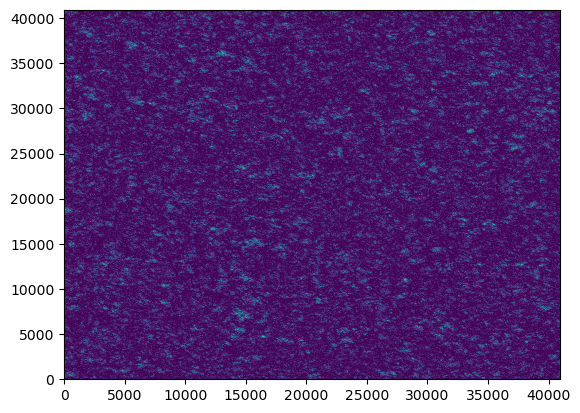

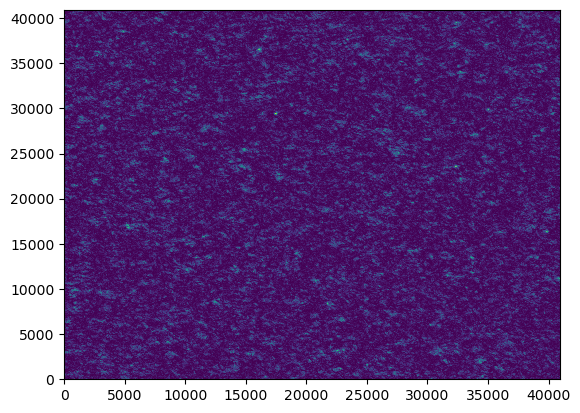

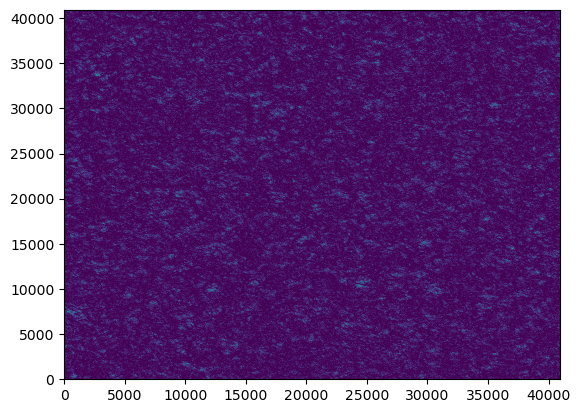

In [35]:
surfGen = SurfGenerator(Ekxky_for_surf.values,kX[0,:],kY[:,0])

print('-----------------------------------------')

for i in range(3):
    print(i)
    S_r,S_i,X,Y = surfGen(tf.constant(i))
    plt.figure()
    plt.pcolormesh(X,Y,S_r**2+S_i**2)

<tf.Variable 'UnreadVariable' shape=(4094, 4096) dtype=complex64, numpy=
array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
      dtype=complex64)>

In [9]:
kX

array([[-0.31415927, -0.31385247, -0.31354567, ...,  0.31323888,
         0.31354567,  0.31385247],
       [-0.31415927, -0.31385247, -0.31354567, ...,  0.31323888,
         0.31354567,  0.31385247],
       [-0.31415927, -0.31385247, -0.31354567, ...,  0.31323888,
         0.31354567,  0.31385247],
       ...,
       [-0.31415927, -0.31385247, -0.31354567, ...,  0.31323888,
         0.31354567,  0.31385247],
       [-0.31415927, -0.31385247, -0.31354567, ...,  0.31323888,
         0.31354567,  0.31385247],
       [-0.31415927, -0.31385247, -0.31354567, ...,  0.31323888,
         0.31354567,  0.31385247]])

In [24]:

print(Ekxky_for_surf.shape) # ny, nx
print(kX.shape)

(4094, 4096)
(4094, 4096)


In [52]:
rng = np.random.default_rng(i)
rg = rng.normal(0,1,(ny_big,nx_big))
zhats=np.fft.ifftshift(np.sqrt(2*Ekxky_for_surf.values*dkx*dky)*np.exp(1j*2*np.pi*rg))
ky2D=np.fft.ifftshift(kY) 
kx2D=np.fft.ifftshift(kX) 

#     real part
S2_r = np.real(np.fft.ifft2(zhats,norm="forward"))
#     also computes imaginary part (useful for envelope calculations) 
S2_i = np.imag(np.fft.ifft2(zhats,norm="forward"))

X = np.arange(0,np.floor(nx_big*dx_big),dx_big) # from 0 to (nx-1)*dx with a dx step
Y = np.arange(0,np.floor(ny_big*dy_big),dy_big)

In [54]:
S = tf.signal.fft2d(zhats)

/tmp/ipykernel_54045/2662285342.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(Y,X,tf.transpose(tf.math.real(S)),cmap=cmap)
/tmp/ipykernel_54045/2662285342.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(Y,X,tf.transpose(tf.math.imag(S)),cmap=cmap)
/tmp/ipykernel_54045/2662285342.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the cor

(15000.0, 35000.0)

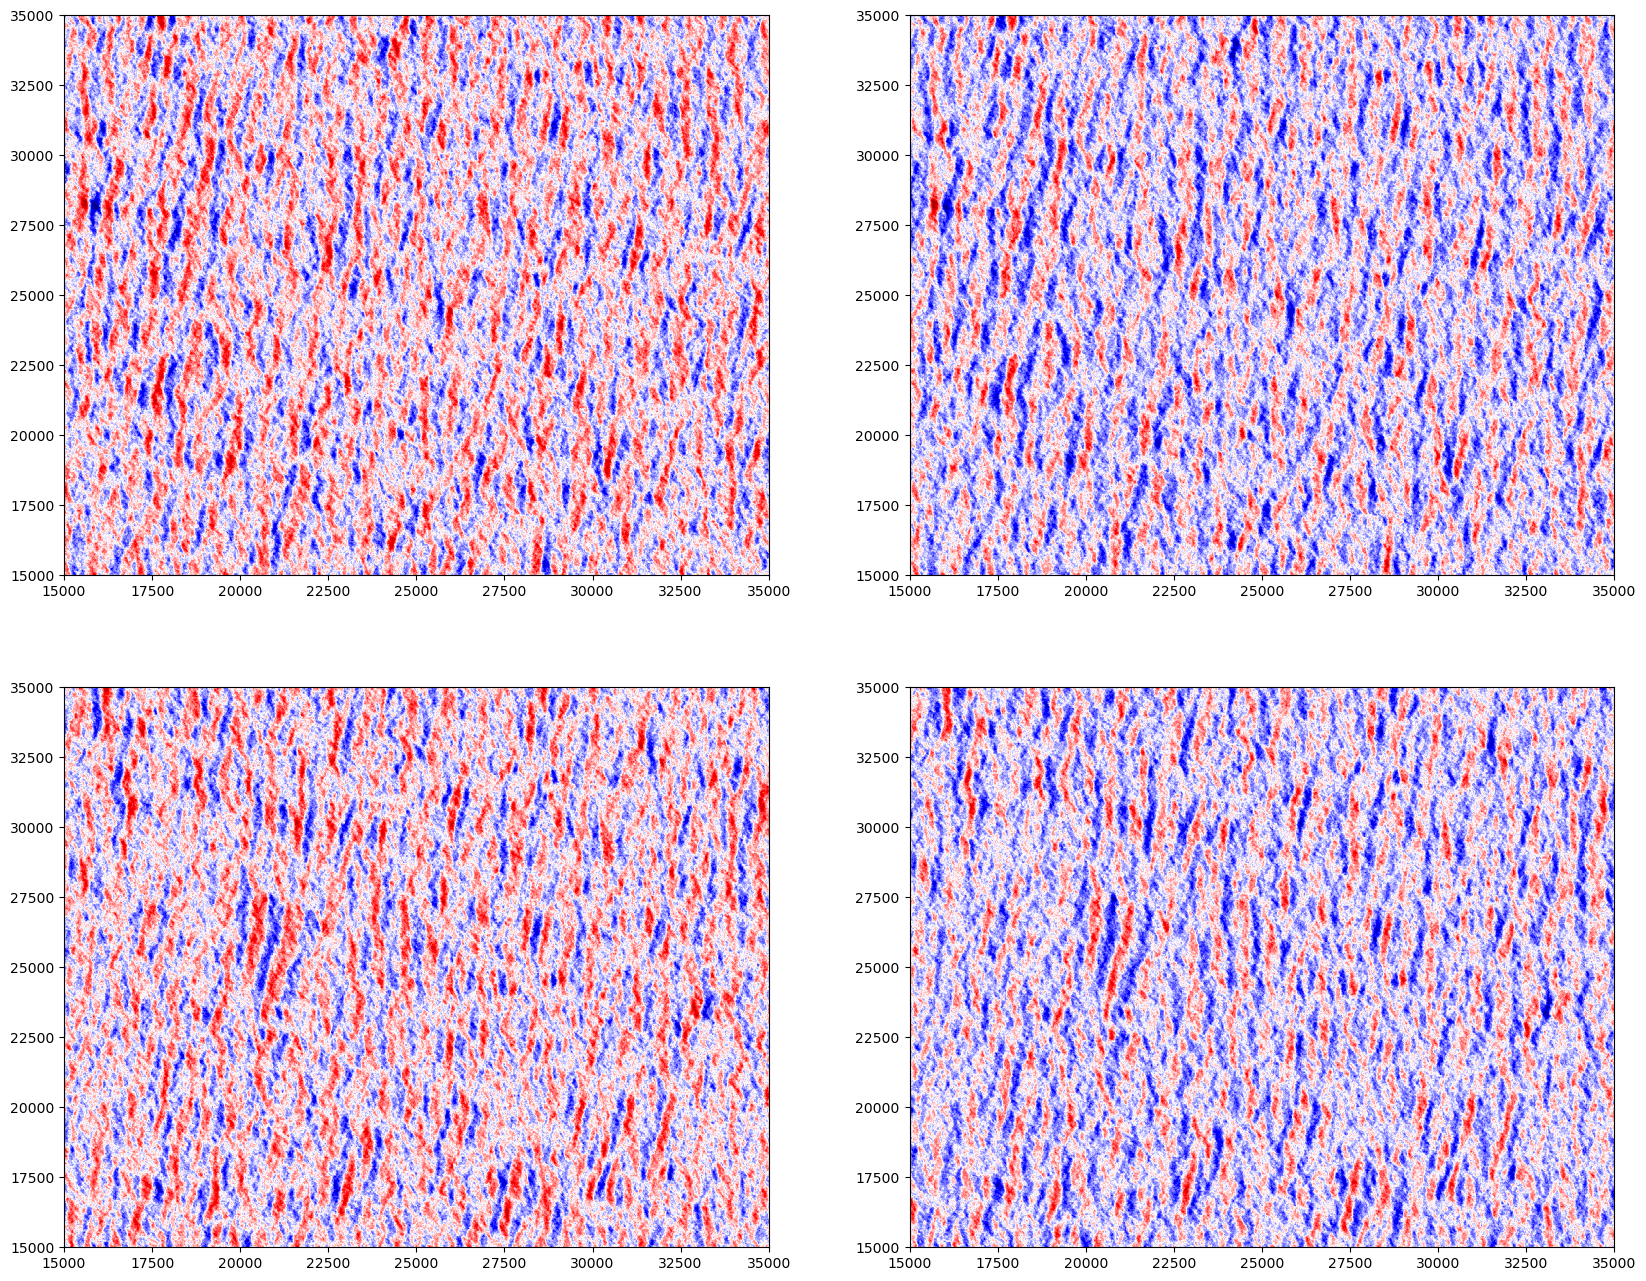

In [59]:
fig,axs=plt.subplots(2,2,figsize=(20,16))

cmap='seismic'
ax=axs[0,0]
ax.pcolormesh(Y,X,tf.transpose(tf.math.real(S)),cmap=cmap)
ax.set_xlim([15*1e3, 35*1e3])
ax.set_ylim([15*1e3, 35*1e3])

ax=axs[0,1]
ax.pcolormesh(Y,X,tf.transpose(tf.math.imag(S)),cmap=cmap)
ax.set_xlim([15*1e3, 35*1e3])
ax.set_ylim([15*1e3, 35*1e3])

ax=axs[1,0]
ax.pcolormesh(Y,X,S2_r.T,cmap=cmap)
ax.set_xlim([15*1e3, 35*1e3])
ax.set_ylim([15*1e3, 35*1e3])

ax=axs[1,1]
ax.pcolormesh(Y,X,S2_i.T,cmap=cmap)
ax.set_xlim([15*1e3, 35*1e3])
ax.set_ylim([15*1e3, 35*1e3])

In [61]:
i=25
tf.random.set_seed(i)
rg = tf.random.uniform(shape=[ny_big,nx_big])
dkx = 2*np.pi/(dx_big*nx_big)
dky = 2*np.pi/(dy_big*ny_big)

zhats = tf.signal.ifftshift(tf.math.sqrt(2*var*dkx*dky)*tf.math.exp(tf.constant(1j,dtype=tf.complex64) * tf.cast(tf.constant(2*np.pi*rg),dtype=tf.complex64)))
ky2D = tf.signal.ifftshift(kY) 
kx2D = tf.signal.ifftshift(kX)

S = tf.signal.fft2d(zhats)
S_r = tf.math.real(S)
S_i = tf.math.imag(S)

X = tf.range(0,(nx_big*dx_big),delta=dx_big) # from 0 to (nx-1)*dx with a dx step
Y = tf.range(0,(ny_big*dy_big),delta=dy_big)


# Verif by JM

In [5]:
# init 
@tf.function
def surface_2D_from_Z1kxky(Z1,kX,kY,iseed):
    #,nx=None,ny=None,dx=None,dy=None, dkx=None, dky=None, phase_type='uniform', verbose=True):
    # /!\ Watch out : shape(S) = (ny,nx)
    # usually when doing X,Y=np.meshgrid(x,y) with size(x)=nx and size(y)=ny => size(X)=size(Y)= (ny,nx)
    kX0 = kX[0,:]
    kY0 = kY[:,0]

    nx = len(kX0)
    ny = len(kY0)

    print('from vec kX0, dkx = ',(kX0[1] - kX0[0]))
    print('from vec kY0, dky = ',(kY0[1] - kY0[0]))

    dx = 2*np.pi/((kX0[1] - kX0[0])*nx)
    dy = (2*np.pi/((kY0[1] - kY0[0])*ny))
    
    dkx = tf.cast(2*np.pi/(dx*nx),dtype=tf.complex64)
    dky = tf.cast(2*np.pi/(dy*ny),dtype=tf.complex64)       
   
    print("variables : ")
    print(' dx = ',dx,' ; dy = ',dy,' ; nx = ',nx,' ; ny = ',ny)
    print('dkx = ',dkx,' ; dky = ', dky)
    #
    #  Defines random phases with seed i
    #
    print(iseed)
    # tf.random.set_seed(0)
    S_r = {}
    S_i = {}
    for k in range(10):
        rg = tf.random.uniform(shape=[ny,nx])#,seed=iseed)
        print(type(dkx),dkx.shape)
        zhats = tf.signal.ifftshift(tf.math.sqrt(2*tf.cast(Z1,dtype=tf.complex64)*dkx*dky)*
                                    tf.math.exp(tf.constant(1j,dtype=tf.complex64) 
                                                * tf.cast(tf.constant(2*np.pi)*rg,dtype=tf.complex64)))
        ky2D = tf.signal.ifftshift(kY) 
        kx2D = tf.signal.ifftshift(kX)


        S = tf.signal.fft2d(zhats)
        #     real part
        S = tf.signal.fft2d(zhats)
        S_r[k] = tf.math.real(S)
        S_i[k] = tf.math.imag(S)

    X = tf.range(0,(nx*dx),delta=dx) # from 0 to (nx-1)*dx with a dx step
    Y = tf.range(0,(ny*dy),delta=dy)

    return S_r,S_i,X,Y#,kX0,kY0,i,dkx,dky


In [6]:
%%time
A = tf.constant(Ekxky_for_surf.values)
B = tf.constant(kX)
C = tf.constant(kY)
D = tf.Variable(0,dtype=tf.int32)
tf.random.set_seed(0)
for iseed in range(50):
    
    D.assign(iseed)
    
    S_r,S_i,X,Y = surface_2D_from_Z1kxky(A,B,C,D)
    # plt.figure()
    # plt.pcolormesh(Y,X,tf.transpose(S_r),cmap='seismic')
    # plt.xlim([15*1e3,35*1e3])
    # plt.ylim([15*1e3,35*1e3])
print('Done ----------------------------------')

from vec kX0, dkx =  Tensor("sub:0", shape=(), dtype=float64)
from vec kY0, dky =  Tensor("sub_1:0", shape=(), dtype=float64)
variables : 
 dx =  Tensor("truediv:0", shape=(), dtype=float64)  ; dy =  Tensor("truediv_1:0", shape=(), dtype=float64)  ; nx =  4096  ; ny =  4094
dkx =  Tensor("Cast:0", shape=(), dtype=complex64)  ; dky =  Tensor("Cast_1:0", shape=(), dtype=complex64)
<tf.Variable 'Variable:0' shape=() dtype=int32>
<class 'tensorflow.python.framework.ops.Tensor'> ()
<class 'tensorflow.python.framework.ops.Tensor'> ()
<class 'tensorflow.python.framework.ops.Tensor'> ()
<class 'tensorflow.python.framework.ops.Tensor'> ()
<class 'tensorflow.python.framework.ops.Tensor'> ()
<class 'tensorflow.python.framework.ops.Tensor'> ()
<class 'tensorflow.python.framework.ops.Tensor'> ()
<class 'tensorflow.python.framework.ops.Tensor'> ()
<class 'tensorflow.python.framework.ops.Tensor'> ()
<class 'tensorflow.python.framework.ops.Tensor'> ()
Done ----------------------------------
CPU times:

# not yet Verif by JM

In [62]:
from functions_cfosat_env import calc_footprint_diam

In [74]:
# init 

def surface_2D_from_Z1kxky(Z1,kX,kY,iseed):
    #,nx=None,ny=None,dx=None,dy=None, dkx=None, dky=None, phase_type='uniform', verbose=True):
    # /!\ Watch out : shape(S) = (ny,nx)
    # usually when doing X,Y=np.meshgrid(x,y) with size(x)=nx and size(y)=ny => size(X)=size(Y)= (ny,nx)
    kX0 = kX[0,:]
    kY0 = kY[:,0]

    nx = len(kX0)
    ny = len(kY0)

    print('from vec kX0, dkx = ',(kX0[1] - kX0[0]))
    print('from vec kY0, dky = ',(kY0[1] - kY0[0]))

    dx = 2*np.pi/((kX0[1] - kX0[0])*nx)
    dy = (2*np.pi/((kY0[1] - kY0[0])*ny))
    
    dkx = tf.cast(2*np.pi/(dx*nx),dtype=tf.complex64)
    dky = tf.cast(2*np.pi/(dy*ny),dtype=tf.complex64)       
   
    print("variables : ")
    print(' dx = ',dx,' ; dy = ',dy,' ; nx = ',nx,' ; ny = ',ny)
    print('dkx = ',dkx,' ; dky = ', dky)
    #
    #  Defines random phases with seed i
    #
    print(iseed)
    # tf.random.set_seed(0)
    # S_r = {}
    # S_i = {}
    # for k in range(10):
    rg = tf.random.uniform(shape=[ny,nx])#,seed=iseed)
    print(type(dkx),dkx.shape)
    zhats = tf.signal.ifftshift(tf.math.sqrt(2*tf.cast(Z1,dtype=tf.complex64)*dkx*dky)*
                                tf.math.exp(tf.constant(1j,dtype=tf.complex64) 
                                            * tf.cast(tf.constant(2*np.pi)*rg,dtype=tf.complex64)))
    ky2D = tf.signal.ifftshift(kY) 
    kx2D = tf.signal.ifftshift(kX)


    S = tf.signal.fft2d(zhats)
    #     real part
    S = tf.signal.fft2d(zhats)
    # S_r[k] = tf.math.real(S)
    # S_i[k] = tf.math.imag(S)
    S_r = tf.math.real(S)
    S_i = tf.math.imag(S)

    X = tf.range(0,(nx*dx),delta=dx) # from 0 to (nx-1)*dx with a dx step
    Y = tf.range(0,(ny*dy),delta=dy)

    return S_r,S_i,X,Y#,kX0,kY0,i,dkx,dky


def waveforms_from_simu(X,Y,S1,nsampx,nsampy,nxa0,nxa,di,ranges,range_offset=10,alti_sat=519*1e3,Gamma=1.):
    ialtx=nxa0+np.arange(nsampx)*di
    Xalt = tf.constant(X[ialtx])
    ialty=nxa0+np.arange(nsampy)*di
    Yalt = tf.constant(Y[ialty])

    waveforms = tf.constant((nsampx,nsampy,len(ranges)-1))
                    
    dx = tf.constant(X[1]-X[0],dtype=tf.float32)
    dy = tf.constant(Y[1]-Y[0],dtype=tf.float32)
    ny=len(Y)
    stepy=1
    shifty1=0
    Ri = tf.constant(6378.1363*(10**3),dtype=tf.float32) #Earth radius
      
    # --- Footprint definition For std(surface) --------------------
    [Xa0,Ya0]=tf.meshgrid(dx*tf.range(-nxa,nxa+1,dtype=tf.float32), dy*tf.range(-nxa,nxa+1,dtype=tf.float32))

    dr = tf.constant(ranges[1]-ranges[0],dtype=tf.float32)
    dr2 = tf.constant(0.5,dtype=tf.float32)*dr
    Apix = tf.constant(np.pi*2,dtype=tf.float32)*tf.constant(alti_sat,dtype=tf.float32)* dr / (dx**2) # The area of a ring, in terms of pixels 

    r2 = Xa0**2+Ya0**2
    # Uses 2-way antenna pattern to reduce backscattered power 
    power = tf.math.exp(-(tf.constant(4,dtype=tf.float32)*(r2/tf.constant(alti_sat**2,dtype=tf.float32))
                        *(tf.constant(1,dtype=tf.float32)+tf.constant(alti_sat,dtype=tf.float32)/Ri)
                        /tf.constant(Gamma,dtype=tf.float32)))
    # ----------------------------------------------------
    # -- Comes from FSSR(t): -----------------------------
    # FSSR(t) = A * P * exp ( -ct/h * (4/Gamma)) * I0(beta* t**0.5) 
    # ct = 2 * distance
    # when flat Earth : 
    # distance = np.sqrt(alti_sat**2+r2) ~ alti_sat *( 1 + 0.5* r2/alti_sat**2)
    # when spherical Earth :
    # distance = np.sqrt(alti_sat**2 + r2*(1 + alti_sat/Ri)) ~ alti_sat *( 1 + 0.5 * r2/alti_sat**2 * (1+alti_sat/Ri)

    waveforms = {}
    for isampx in range(nsampx):
        for isampy in range(nsampy):             
            # --- get surface extract for altimeter ---------------------------
            surf1 = tf.constant(S1[ialty-nxa:ialty+nxa+1,ialtx-nxa:ialtx+nxa+1],dtype=tf.float32)                        
            # --- to have distance to satellite = range -------------------
            r=tf.math.sqrt(r2+(tf.constant(alti_sat,dtype=tf.float32)-surf1)**2) -tf.constant(alti_sat,dtype=tf.float32)+tf.constant(range_offset,dtype=tf.float32)
            
            #print(isampx,isampy,ialtx,ialty,np.max(r),np.min(r))
            # --- histogram counts the number of data points between edges ...
            #     modified by FA to center the range values
            bins2D = tf.broadcast_to(tf.constant(ranges-dr2.numpy(),dtype=tf.float32),
                                     [tf.size(surf1),tf.size(ranges)])
            new_values_2D = tf.broadcast_to(tf.reshape(r,[tf.size(surf1),1]),
                                [tf.size(surf1),tf.size(ranges)-1])

            weights_2D = tf.broadcast_to(tf.reshape(power,[tf.size(surf1),1]),
                                [tf.size(surf1),tf.size(ranges)-1])
            
            cond = (bins2D[:,0:-1]<=new_values_2D) & (bins2D[:,1:]>new_values_2D)
            counts = tf.reduce_sum(tf.cast(cond,dtype=tf.float32)*weights_2D,axis=0)
            
            waveform=counts/Apix
            waveforms[isampx,isampy]=waveform            

    return Xalt,Yalt,waveforms

@tf.function
def compute_for_var_seeds(Ekxky_tf,kX_tf,kY_tf,DiamChelton,nseed,alti_sat = 519*1e3 ,theta3dB=1.6*np.pi/180.):
    # ---- Physical constants for alti -----------------------------
    clight = tf.constant(299792458,dtype=tf.float32)
    Rearth = tf.constant(6370*1e3,dtype=tf.float32)
    v_sat = tf.constant(7*1e3,dtype=tf.float32)
    bandwidth = tf.constant(400*1e6,dtype=tf.float32)
    tau = tf.constant(1e9)/bandwidth
    freq_satsampl = tf.constant(20, dtype=tf.float32)
    # ---- Range gates -----------------------------
    dr = clight * 1/(2*bandwidth)
    nominal_tracking_gate=70
    
    range_offset = nominal_tracking_gate*dr
    ranges = tf.range(0,127*dr,delta=dr,dtype=tf.float32)
    
    # ---- Surface sampling ----------------------------
    nx = tf.size(kX_tf[0,:])
    ny = tf.size(kY_tf[:,0])
    dx = tf.constant(2*np.pi,dtype=tf.float32)/(tf.cast((kX_tf[0,1] - kX_tf[0,0]),dtype=tf.float32)*tf.cast(nx,dtype=tf.float32))
    dy = tf.constant(2*np.pi,dtype=tf.float32)/(tf.cast((kY_tf[1,0] - kY_tf[0,0]),dtype=tf.float32)*tf.cast(ny,dtype=tf.float32))
    
    di = tf.cast(tf.floor((v_sat/freq_satsampl)/dx),dtype=tf.int32) # distance between footprint centers, in pixels (v_sat/freq_satsampl = dsitance in m)

    nxa0 = tf.cast(tf.floor(10*1e3/dx),dtype=tf.int32) # maximum size of footprint radius [in pixel], set as margin
    nsampx = tf.cast(tf.floor((nx - 2*nxa0)/di),dtype=tf.int32) # Nb of samples : Nb of pixel - margins
    nsampy = tf.cast(tf.floor((ny - 2*nxa0)/di),dtype=tf.int32) # Nb of samples : Nb of pixel - margins
    
    nxa = tf.cast(tf.floor(DiamChelton/dx),dtype=tf.int32)
    Gamma = tf.constant(0.5,dtype=tf.float32) * (tf.constant(1.0,dtype=tf.float32)/tf.math.log(2.0))*tf.math.sin(theta3dB)*tf.math.sin(theta3dB)

    D = tf.Variable(0,dtype=tf.int32)
    tf.random.set_seed(0)
    waveforms = {}
    for iseed in range(nseed):
        D.assign(iseed)
        S_r,S_i,X,Y = surface_2D_from_Z1kxky(A,B,C,D)
        
        Xalt,Yalt,waveforms[k]=waveforms_from_simu(X,Y,S_r,nsampx,nsampy,nxa0,nxa,di,ranges,range_offset=range_offset,alti_sat=alti_sat,Gamma=Gamma)

    return waveforms

In [75]:
%%time
A = tf.constant(Ekxky_for_surf.values)
B = tf.constant(kX)
C = tf.constant(kY)
D = tf.Variable(0,dtype=tf.int32)
alti_sat = 519*1e3
bandwidth = 400*1e6
diamChelton = calc_footprint_diam(Hs_35,Rorbit = alti_sat, pulse_width=1/bandwidth)


waveforms = compute_for_var_seeds(A,B,C,tf.constant(diamChelton,dtype=tf.float32),6,
                                  alti_sat = 519*1e3 ,theta3dB=1.6*np.pi/180.)


from vec kX0, dkx =  Tensor("sub_4:0", shape=(), dtype=float64)
from vec kY0, dky =  Tensor("sub_5:0", shape=(), dtype=float64)
variables : 
 dx =  Tensor("truediv_11:0", shape=(), dtype=float64)  ; dy =  Tensor("truediv_12:0", shape=(), dtype=float64)  ; nx =  4096  ; ny =  4094
dkx =  Tensor("Cast_9:0", shape=(), dtype=complex64)  ; dky =  Tensor("Cast_10:0", shape=(), dtype=complex64)
<tf.Variable 'Variable:0' shape=() dtype=int32>
<class 'tensorflow.python.framework.ops.Tensor'> ()


NotImplementedError: in user code:

    File "/tmp/ipykernel_7660/878132666.py", line 157, in compute_for_var_seeds  *
        Xalt,Yalt,waveforms[k]=waveforms_from_simu(X,Y,S_r,nsampx,nsampy,nxa0,nxa,di,ranges,range_offset=range_offset,alti_sat=alti_sat,Gamma=Gamma)
    File "/tmp/ipykernel_7660/878132666.py", line 57, in waveforms_from_simu  *
        ialtx=nxa0+np.arange(nsampx)*di

    NotImplementedError: Cannot convert a symbolic tf.Tensor (Cast_6:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.


In [5]:
from altimetry_waveforms_functions import simu_waveform_erf

In [ ]:
	S2_r,S2_i,X,Y,kX0,kY0,rg,dkx,dky = surface_2D_from_Z1kxky(Ekxky_for_surf,kX,kY,seed)

	return S2_r,S2_i,X,Y,rg,kX0,kY0,Ekxky_for_surf,dkx,dky

In [ ]:
S_r_35_big,S_i_35_big,Xa_35_big,Ya_35_big,\
rg,kX2_35_big,kY2_35_big,Ekxky_35_big,dkx2_35,dky2_35 = surface_from_Efth(Efth,f_vec,th_vec,
                                                                    seed=seed,nx=nx_big,
                                                                    ny=ny_big,dx=dx_big,dy=dy_big,iswvnb=1)